In [5]:
from efficientnet_pytorch import EfficientNet

import torch.nn as nn
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cv2

In [6]:
! nvidia-smi

Thu Dec 12 01:43:06 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.104      Driver Version: 410.104      CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    40W / 300W |      0MiB / 16130MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [7]:
class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x

class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        #  would be a nice idea if the upsampling could be learned too,
        #  but my machine do not have enough memory to handle all those weights
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2=None):
        x1 = self.up(x1)
        
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))
        
        # for padding issues, see 
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        
        if x2 is not None:
            x = torch.cat([x2, x1], dim=1)
        else:
            x = x1
        x = self.conv(x)
        return x

def get_mesh(batch_size, shape_x, shape_y):
    mg_x, mg_y = np.meshgrid(np.linspace(0, 1, shape_y), np.linspace(0, 1, shape_x))
    mg_x = np.tile(mg_x[None, None, :, :], [batch_size, 1, 1, 1]).astype('float32')
    mg_y = np.tile(mg_y[None, None, :, :], [batch_size, 1, 1, 1]).astype('float32')
    mesh = torch.cat([torch.tensor(mg_x).to(device), torch.tensor(mg_y).to(device)], 1)
    return mesh

In [8]:
class MyUNet(nn.Module):
    '''Mixture of previous classes'''
    def __init__(self, n_classes):
        super(MyUNet, self).__init__()
        self.base_model = EfficientNet.from_pretrained('efficientnet-b0')
        
        self.conv0 = double_conv(5, 64)
        self.conv1 = double_conv(64, 128)
        self.conv2 = double_conv(128, 512)
        self.conv3 = double_conv(512, 1024)
        
        self.mp = nn.MaxPool2d(2)
        
        self.up1 = up(1282 + 1024, 512)
        self.up2 = up(512 + 512, 256)
        self.outc = nn.Conv2d(256, n_classes, 1)

    def forward(self, x):
        batch_size = x.shape[0]
        mesh1 = get_mesh(batch_size, x.shape[2], x.shape[3])
        x0 = torch.cat([x, mesh1], 1)
        x1 = self.mp(self.conv0(x0))
        x2 = self.mp(self.conv1(x1))
        x3 = self.mp(self.conv2(x2))
        x4 = self.mp(self.conv3(x3))
        
        x_center = x[:, :, :, IMG_WIDTH // 8: -IMG_WIDTH // 8]
        feats = self.base_model.extract_features(x_center)
        bg = torch.zeros([feats.shape[0], feats.shape[1], feats.shape[2], feats.shape[3] // 8]).to(device)
        feats = torch.cat([bg, feats, bg], 3)
        
        # Add positional info
        mesh2 = get_mesh(batch_size, feats.shape[2], feats.shape[3])
        feats = torch.cat([feats, mesh2], 1)
        
        x = self.up1(feats, x4)
        x = self.up2(x, x3)
        x = self.outc(x)
        return x

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [10]:
PATH='./model.pth'
model = MyUNet(8).to(device)
model.load_state_dict(torch.load(PATH))

Loaded pretrained weights for efficientnet-b0


<All keys matched successfully>

In [11]:
def evaluate_model(epoch, history=None):
    model.eval()
    loss = 0
    
    with torch.no_grad():
        for img_batch, mask_batch, regr_batch in dev_loader:
            img_batch = img_batch.to(device)
            mask_batch = mask_batch.to(device)
            regr_batch = regr_batch.to(device)

            output = model(img_batch)

            loss += criterion(output, mask_batch, regr_batch, size_average=False).data
    
    loss /= len(dev_loader.dataset)
    
    if history is not None:
        history.loc[epoch, 'dev_loss'] = loss.cpu().numpy()
    
    print('Dev loss: {:.4f}'.format(loss))

In [12]:
# print(model)

In [13]:
# load data
PATH='data/'
train = pd.read_csv(PATH + 'train.csv')
test = pd.read_csv(PATH + 'sample_submission.csv')

# From camera.zip
camera_matrix = np.array([[2304.5479, 0,  1686.2379],
                          [0, 2305.8757, 1354.9849],
                          [0, 0, 1]], dtype=np.float32)
camera_matrix_inv = np.linalg.inv(camera_matrix)

train.head()

,ImageId,PredictionString
0,ID_8a6e65317,16 0.254839 -2.57534 -3.10256 7.96539 3.20066 ...
1,ID_337ddc495,66 0.163988 0.192169 -3.12112 -3.17424 6.55331...
2,ID_a381bf4d0,43 0.162877 0.00519276 -3.02676 2.1876 3.53427...
3,ID_7c4a3e0aa,43 0.126957 -3.04442 -3.10883 -14.738 24.6389 ...
4,ID_8b510fad6,37 0.16017 0.00862796 -3.0887 -3.04548 3.4977 ...


In [14]:
def str2coords(s, names=['id', 'yaw', 'pitch', 'roll', 'x', 'y', 'z']):
    '''
    Input:
        s: PredictionString (e.g. from train dataframe)
        names: array of what to extract from the string
    Output:
        list of dicts with keys from `names`
    '''
    coords = []
    for l in np.array(s.split()).reshape([-1, 7]):
        coords.append(dict(zip(names, l.astype('float'))))
        if 'id' in coords[-1]:
            coords[-1]['id'] = int(coords[-1]['id'])
    return coords

In [15]:
#convert it to dict
str2coords(train['PredictionString'][0])
# lens = [len(str2coords(s)) for s in train['PredictionString']]
# sns.countplot(lens);
points_df = pd.DataFrame()
for col in ['x', 'y', 'z', 'yaw', 'pitch', 'roll']:
    arr = []
    for ps in train['PredictionString']:
        coords = str2coords(ps)
        arr += [c[col] for c in coords]
    points_df[col] = arr

print('len(points_df)', len(points_df))
points_df.head()

len(points_df) 49684


,x,y,z,yaw,pitch,roll
0,7.96539,3.20066,11.0225,0.254839,-2.57534,-3.10256
1,9.60332,4.66632,19.3390,0.181647,-1.46947,-3.12159
2,10.39000,11.22190,59.7825,0.163072,-1.56865,-3.11754
3,-9.59236,5.13662,24.7337,0.141942,-3.13950,3.11969
4,9.83335,13.26890,72.9323,0.163068,-2.08578,-3.11754


In [65]:
def imread(path, fast_mode=False):
    img = cv2.imread(path)
    if not fast_mode and img is not None and len(img.shape) == 3:
        img = np.array(img[:, :, ::-1])
    return img


def get_img_coords(s):
    '''
    Input is a PredictionString (e.g. from train dataframe)
    Output is two arrays:
        xs: x coordinates in the image (row)
        ys: y coordinates in the image (column)
    '''
    coords = str2coords(s)
    xs = [c['x'] for c in coords]
    ys = [c['y'] for c in coords]
    zs = [c['z'] for c in coords]
    P = np.array(list(zip(xs, ys, zs))).T
    img_p = np.dot(camera_matrix, P).T
    img_p[:, 0] /= img_p[:, 2]
    img_p[:, 1] /= img_p[:, 2]
    img_xs = img_p[:, 0]
    img_ys = img_p[:, 1]
    img_zs = img_p[:, 2] # z = Distance from the camera
    return img_xs, img_ys


,4,5,6,xs,ys
0,-1.613040,3.245300,10.806900,1342.260654,2047.436770
1,-6.194730,2.885590,9.589130,197.463468,2048.875962
2,-8.965790,5.055310,24.403799,839.562722,1832.652958
3,-20.625601,12.400900,69.371002,1001.042629,1767.187864
4,-12.083300,12.118100,65.699600,1262.391452,1780.296931
5,-8.239250,12.179800,64.439903,1391.579700,1790.818954
6,-5.221470,11.043300,59.313801,1483.365608,1784.302787
7,-2.953360,9.846660,51.086300,1553.009252,1799.432285
8,414.743988,689.119019,3486.530029,1960.377932,1810.745398
9,26.446100,13.923200,64.634300,2629.178473,1851.705165


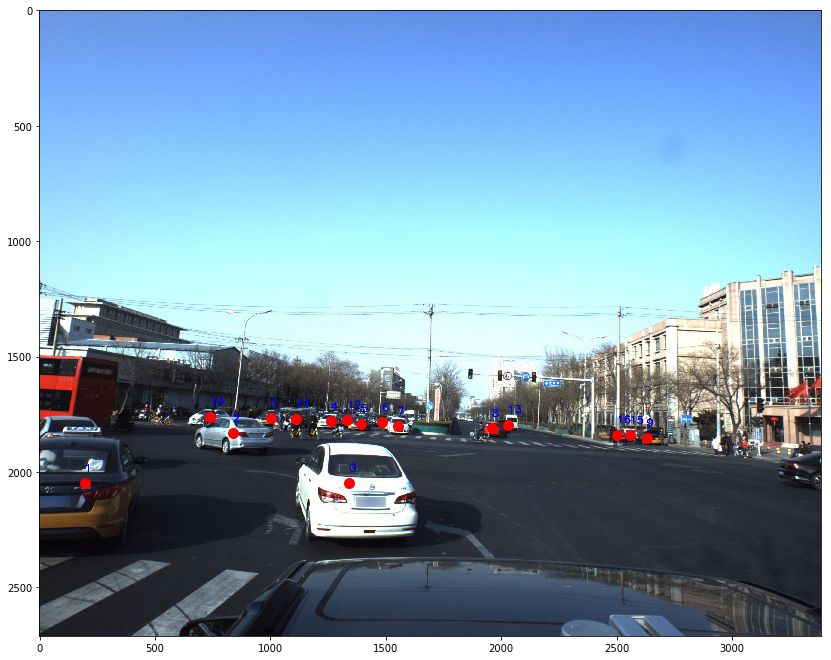

In [66]:
img_ID=2217

plt.figure(figsize=(14,14))
img=imread(PATH + 'train_images/' + train['ImageId'][img_ID] + '.jpg')
plt.scatter(*get_img_coords(train['PredictionString'][img_ID]), color='red', s=100);

_3d_points= np.array(train['PredictionString'][img_ID].split(' ')).astype(np.float32).reshape([-1,7])
_3d_points =pd.DataFrame(_3d_points )
_3d_points['xs']=get_img_coords(train['PredictionString'][img_ID])[0]
_3d_points['ys']=get_img_coords(train['PredictionString'][img_ID])[1]

# plt.scatter(1342,2047, color='green', s=100);
# plt.scatter(197,2048, color='green', s=100);
# plt.scatter(2028,1794, color='green', s=100);
# plt.scatter(2028,1794, color='green', s=100);
font = cv2.FONT_HERSHEY_SIMPLEX

for i in range(len(_3d_points)):
    cv2.putText(img, str(i), (int(_3d_points['xs'][i]),int(_3d_points['ys'][i]-50)), font, 1.5, (0, 0, 255), 4, cv2.LINE_AA)
    
plt.imshow(img)
_3d_points[[4,5,6,'xs','ys']]

,4,5,6,xs,ys
0,-3.700820,2.75048,8.237750,650.916768,2124.887456
1,24.115200,9.12637,39.589199,3090.020572,1886.550924
2,26.212000,10.36310,47.136101,2967.778142,1861.942817
3,-26.079901,15.76450,93.286499,1041.960581,1744.655158
4,-30.922199,16.90420,101.283997,982.655024,1739.833255
5,14.936800,4.79710,18.778700,3519.302523,1944.030776
6,0.503844,13.45660,68.389198,1703.216219,1808.700470


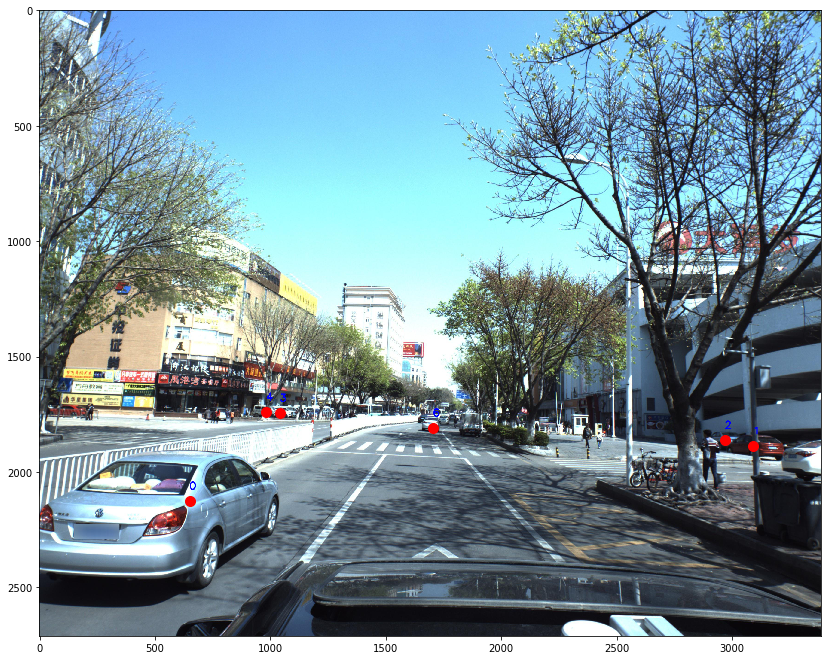

In [68]:
img_ID=2215

plt.figure(figsize=(14,14))
img=imread(PATH + 'train_images/' + train['ImageId'][img_ID] + '.jpg')
plt.scatter(*get_img_coords(train['PredictionString'][img_ID]), color='red', s=100);

_3d_points= np.array(train['PredictionString'][img_ID].split(' ')).astype(np.float32).reshape([-1,7])
_3d_points =pd.DataFrame(_3d_points )
_3d_points['xs']=get_img_coords(train['PredictionString'][img_ID])[0]
_3d_points['ys']=get_img_coords(train['PredictionString'][img_ID])[1]

# plt.scatter(1342,2047, color='green', s=100);
# plt.scatter(197,2048, color='green', s=100);
# plt.scatter(2028,1794, color='green', s=100);
# plt.scatter(2028,1794, color='green', s=100);
font = cv2.FONT_HERSHEY_SIMPLEX

for i in range(len(_3d_points)):
    cv2.putText(img, str(i), (int(_3d_points['xs'][i]),int(_3d_points['ys'][i]-50)), font, 1.5, (0, 0, 255), 4, cv2.LINE_AA)
    
plt.imshow(img)
_3d_points[[4,5,6,'xs','ys']]